## Data 

In [3]:
import pandas as pd
df = pd.read_csv("know_voz_think.csv")

In [4]:
df.head()

,User,Reply_To,Original_Comment,Reply_Content,Title,OriginalUser,positive,negative,neutral
0,thuyvan,NaN,NaN,Vì thread Hậu bầu cử ver 1 bị khóa do Google q...,Hậu bầu cử Mỹ ver 2 | Official Thread,thuyvan,0.986310,0.004254,0.009436
1,theoluat,NaN,NaN,lại bị quét,Hậu bầu cử Mỹ ver 2 | Official Thread,thuyvan,0.948661,0.008844,0.042495
2,eragonhnn,NaN,NaN,xí,Hậu bầu cử Mỹ ver 2 | Official Thread,thuyvan,0.001819,0.992709,0.005472
3,Vive la Nation,NaN,NaN,Uýnh dấu,Hậu bầu cử Mỹ ver 2 | Official Thread,thuyvan,0.001499,0.992045,0.006456
4,Anh Ba Ngọc Sơn,NaN,NaN,Mấy topic hay khi mà dài quá sẽ bị GG nó quét ...,Hậu bầu cử Mỹ ver 2 | Official Thread,thuyvan,0.526083,0.165790,0.308127


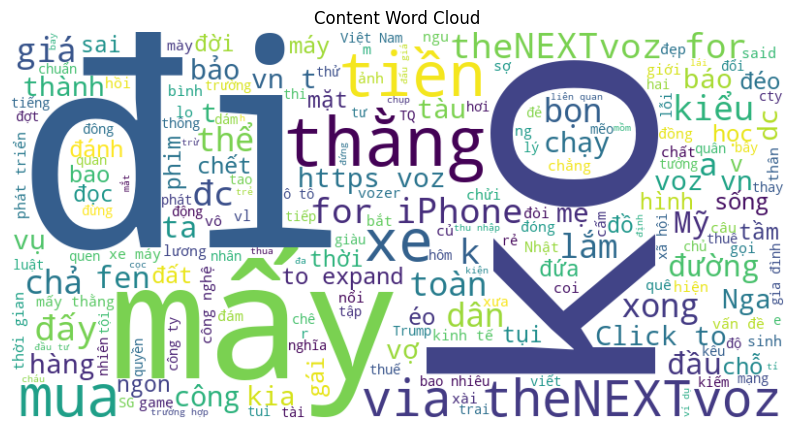

In [5]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
content = ' '.join([str(x) for x in df['Reply_Content'] if x is not None])
stopwords = pd.read_table('vietnamese-stopwords.txt', header=None)[0].tolist()
content_wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=stopwords).generate(content)

plt.figure(figsize=(10, 6))
plt.imshow(content_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Content Word Cloud')
plt.show()

##  Model

![Alt Text](image/model.png)

In [1]:
from fastapi import FastAPI, Request
from pydantic import BaseModel
import uvicorn
from lightrag import LightRAG, QueryParam
from lightrag.llm import hf_model_complete, hf_embedding,zhipu_complete_if_cache
from lightrag.utils import EmbeddingFunc
from transformers import AutoModel, AutoTokenizer
from dotenv import load_dotenv
import os

load_dotenv()
#
ZHIPU_API_KEY = os.getenv("ZHIPU_API_KEY")
WORKING_DIR = os.getenv("WORKING_DIR")

# neo4j
BATCH_SIZE_NODES = 500
BATCH_SIZE_EDGES = 100
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "12345678"



async def llm_model_func(
    prompt, system_prompt=None, history_messages=[], keyword_extraction=False, **kwargs
) -> str:
    return await zhipu_complete_if_cache(
        prompt=prompt,
        model="glm-4-flash",
        system_prompt=system_prompt,
        history_messages=history_messages,
        api_key=ZHIPU_API_KEY,
        **kwargs
    )
embedding_func=EmbeddingFunc(
        embedding_dim=384,
        max_token_size=5000,
        func=lambda texts: hf_embedding(
            texts,
            tokenizer=AutoTokenizer.from_pretrained(
                "sentence-transformers/all-MiniLM-L6-v2"
            ),
            embed_model=AutoModel.from_pretrained(
                "sentence-transformers/all-MiniLM-L6-v2"
            ),
        ),
    )
rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=llm_model_func,
    embedding_func=embedding_func,
    graph_storage="Neo4JStorage"
)

c:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:lightrag:Logger initialized for working directory: ./local_neo4jWorkDir
INFO:lightrag:Load KV llm_response_cache with 3 data
INFO:lightrag:Load KV full_docs with 158 data
INFO:lightrag:Load KV text_chunks with 158 data
INFO:nano-vectordb:Load (969, 384) data
INFO:nano-vectordb:Init {'embedding_dim': 384, 'metric': 'cosine', 'storage_file': './local_neo4jWorkDir\\vdb_entities.json'} 969 data
INFO:nano-vectordb:Load (918, 384) data
INFO:nano-vectordb:Init {'embedding_dim': 384, 'metric': 'cosine', 'storage_file': './local_neo4jWorkDir\\vdb_relationships.json'} 918 data
INFO:nano-vectordb:Load (158, 384) data
INFO:nano-vectordb:Init {'embedding_dim': 384, 'metric': 'cosine', 'storage_file': './local_neo4jWorkDir\\vdb_chunks.json'

![Alt Text](image/insert.jpg)

In [ ]:
for i in range(df.shape[0]):
    if pd.notna(df["Reply_To"][i]):
        
        content = "User: " + df["User"][i] + "\nReply : " + df["Reply_Content"][i] + "\n Reply to comment: " + df["Original_Comment"][i] + "\nThat comment of user: " + df["Reply_To"][i] + "\nAbout this topic: " + df["Title"][i]
    else:
        if not pd.notna(df["Reply_Content"][i]):
            continue
        content = "User: " + df["User"][i] + "\nReply : " + df["Reply_Content"][i] + "\nAbout this topic: " + df["Title"][i]
    await rag.ainsert(content)

In [7]:
content

'User: stonecold166.03\nReply : Fact: Mỹ là nước duy nhất nằm trong top 10 GDP lẫn GDP per capita mà có dân số trên 100tr (320tr người tính đến thời điểm hiện tại). Điều này có ý nghĩa gì ? Nghĩa là Mỹ là nước vừa giàu vừa đông dân, tiêu xài cực kỳ mạnh tay (người Việt ở Mỹ có câu "k nợ k phải Mỹ"). 1tỷ6 dân TQ thì to nhưng tầng lớp nghèo của TQ quá đông và văn hóa tiêu dùng của TQ là văn hóa "tiết kiệm" (tức là cần thiết lắm mới mua), Mỹ thì ngược lại mua thoải mái, thích thì cà thẻ mua chán thì bán lại; nên sức mua của thị trường Mỹ nó còn hơn cả TQ. Thế nên là Mỹ dựng rào cản k cho hàng nước nào vào là nước đó phải quỳ lạy liền vì thị trường quá béo bở. Ông Trump biết điều đó và sẵn sàng sử dụng sức mạnh mềm này như một loại vũ khí (thay vì dùng súng đạn), không như những người tiền nhiệm có phần e dè. Trump hiểu sức mạnh mềm của Mỹ có lẽ vì ông là tỷ phú kinh doanh lăn lộn cả đời trên thương trường, điều mà các tổng thống khác k có dc.\n Reply to comment: Đương nhiên là thằng/ con 

## Query

![Alt Text](image/queryjpg.jpg)

In [8]:
messages = []

In [9]:
query = "How everyone talk about america"
result = await rag.aquery(query, param=QueryParam(mode="hybrid"),history_chat = messages)
messages.append({"role": "user", "content": query})
messages.append({"role": "system", "content": result})

Model: glm-4-flash


INFO:httpx:HTTP Request: POST https://open.bigmodel.cn/api/paas/v4/chat/completions "HTTP/1.1 200 OK"
INFO:lightrag:kw_prompt result:
INFO:lightrag:Global query uses 19 entites, 15 relations, 6 text units


Model: glm-4-flash


INFO:httpx:HTTP Request: POST https://open.bigmodel.cn/api/paas/v4/chat/completions "HTTP/1.1 200 OK"


In [14]:
result

[{'role': 'user', 'content': 'How everyone talk about america'},
 {'role': 'system',
  'content': '# Discussion on America in the Forum\n\nIn the provided data, there is a significant amount of discussion surrounding the topic of America, particularly in the context of the 2024 US election and its aftermath. The following sections summarize the key points and themes from the forum discussions:\n\n## Official Thread and Hậu Bầu Cử Mỹ Ver 2\n\nThe "Official Thread" and "Hậu Bầu Cử Mỹ Ver 2" are central to the discussions about America in this forum. The "Hậu Bầu Cử Mỹ Ver 2" event refers to the aftermath of the US election, which is a major topic of conversation within the "Official Thread." This thread is dedicated to continuing the discussion about the post-election situation in the United States, following the closure of the previous thread, "Hậu Bầu Cử Mỹ Ver 1," due to Google blocking it for containing inappropriate content.\n\n## Participants and Their Involvement\n\nSeveral users 

In [15]:
query = "what is that country?"
result = await rag.aquery(query, param=QueryParam(mode="hybrid"),history_chat = messages)
messages.append({"role": "user", "content": query})
messages.append({"role": "system", "content": result})

Model: glm-4-flash


INFO:httpx:HTTP Request: POST https://open.bigmodel.cn/api/paas/v4/chat/completions "HTTP/1.1 200 OK"
INFO:lightrag:kw_prompt result:


{
  "high_level_keywords": ["Country", "Geography", "Identification"],
  "low_level_keywords": ["Specific country", "Place", "Location", "Nationality", "Territory"]
}


INFO:lightrag:Local query uses 3 entites, 1 relations, 4 text units
INFO:lightrag:Global query uses 4 entites, 2 relations, 2 text units


Model: glm-4-flash


INFO:httpx:HTTP Request: POST https://open.bigmodel.cn/api/paas/v4/chat/completions "HTTP/1.1 200 OK"
